In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

def reset_timestamp(df):
    df['timestamp'] = df['timestamp'] - df['timestamp'][0]
    return df

def process_line(line):
    timestamp = line.split(' ')[1]
    content = line.split('  : ')[1]
#     print(content)
    pairs = content.split(',')
#     print(pairs)
    d = {}
    cpugpu = re.search("CPU4/GPU=\d+/\d+,\d+/\d+", content).group()
    cpugpu = cpugpu.split('=')[1]
    cpugpu = cpugpu.split('/')
    d['CPU Level'] = int(cpugpu[0])
    d['GPU Level'] = int(cpugpu[1].split(',')[0])
    d['CPU Frequency (MHz)'] = int(cpugpu[1].split(',')[1])
    d['GPU Frequency (MHz)'] = int(cpugpu[2])
    for x in pairs:
        tmp = x.split('=')
        if tmp[0] == 'CPU4/GPU' or len(tmp) < 2:
            continue
        if tmp[0] == 'FPS':
            d[tmp[0]] = int(tmp[1].split('/')[0])
        elif tmp[0] == 'Free':
            d[tmp[0]] = int(tmp[1][:-2])
        else:
            d[tmp[0]] = tmp[1].strip()
#     print(pairs[0].split('='))
#     d = {x.split('=')[0] : x.split('=')[1] for x in pairs}
#     print(d)
    d["timestamp"] = timestamp
#     print(d)
    return pd.DataFrame(d, index=[0])

def add_to_dataframe(df, timestamp, key, value):
    if key not in df.columns:
        df[key] = np.nan
    df.loc[timestamp, key] = value
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    for line in open(file_path, 'r', encoding='utf-16'):
        if len(line) < 300:
            continue
        new_d = process_line(line)
        df = df.append(new_d)

#     df.index.name = 'timestamp'
#     df = df.reset_index()

    df['device'] = file_path.split('\\')[1]
    df['app'] = file_path.split('\\')[2].strip('-W')
    df['app_details'] = file_path.split('\\')[3]
    df['type'] = file_path.split('\\')[5]
    df['is_wireless'] = file_path.split('\\')[2]
    df['repetition'] = file_path.split('\\')[4].strip('record') if 'record' in file_path.split('\\')[4] else file_path.split('\\')[4].strip('replay')

    df.to_csv(f'.\\{file_path.strip(".log")}.csv', index=False)

    return df

def process_logcat():
    df_aggregated = pd.DataFrame()
    for root, dirs, files in os.walk(".", topdown=False):
        for name in files:
            if name == 'logcat_VrApi.log':
                print(os.path.join(root, name))
                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))]) 
    # df_aggregated
    return df_aggregated


In [2]:
import warnings
warnings.filterwarnings("ignore")

df = process_logcat()
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log


AttributeError: 'DataFrame' object has no attribute 'append'

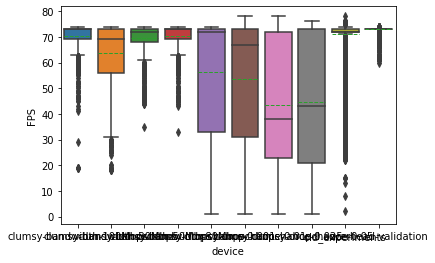

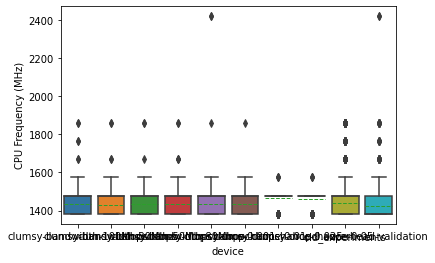

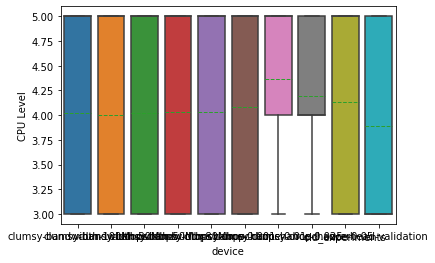

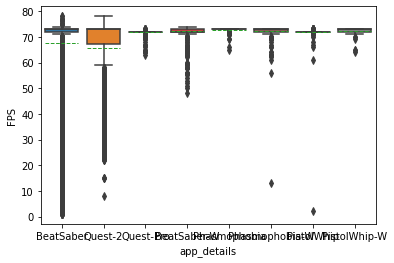

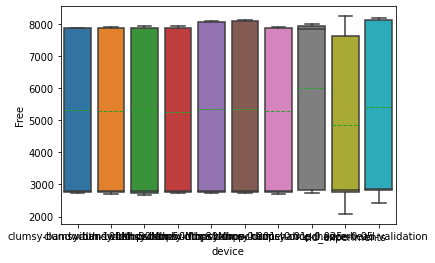

In [ ]:
df[["FPS", "CPU Level", "CPU Frequency (MHz)", "Free"]] = df[["FPS", "CPU Level", "CPU Frequency (MHz)", "Free"]].apply(pd.to_numeric)

sns.boxplot(data=df, x='device', y='FPS', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='device', y='CPU Frequency (MHz)', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='device', y='CPU Level', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='app_details', y='FPS', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='device', y='Free', showmeans=True, meanline=True)
plt.show()


Index(['CPU Level', 'GPU Level', 'CPU Frequency (MHz)', 'GPU Frequency (MHz)',
       'FPS', 'Prd', 'Tear', 'Early', 'Stale', 'Stale2/5/10/max', 'VSnc',
       'Lat', 'Fov', 'OC', 'TA', 'SP', 'Mem', 'Free', 'PLS', 'Temp', 'TW',
       'App', 'GD', 'CPU&GPU', 'LCnt', 'GPU%', 'CPU%', 'DSF', 'CFL', 'ICFLp95',
       'LD', 'SF', 'LP', 'DVFS', 'timestamp', 'device', 'app', 'app_details',
       'type', 'is_wireless', 'repetition'],
      dtype='object')


[Text(0, 0.5, 'FPS'), Text(0.5, 0, 'Quest-2')]

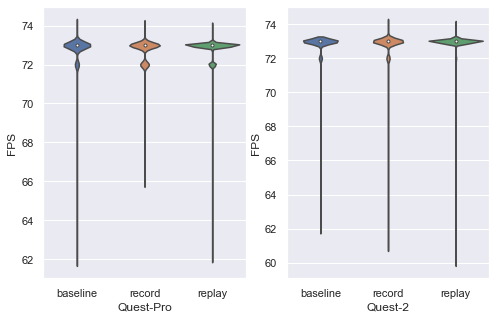

In [ ]:
import matplotlib.pyplot as plt

def simplify_runs(row) :
    if "baseline" in row:
        return 'baseline'
    elif "replay" in row:
        return 'replay'
    else :
        return 'record'


print(temp.columns)

temp = df[df["device"] == 'overhead-validation']

temp['type'] = temp['type'].apply(simplify_runs)

pro = temp[temp['app'] == 'Quest-Pro']
two = temp[temp['app'] == 'Quest-2']

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))

sns.set_theme(palette='deep')
sns.violinplot(ax=axes[0], data=pro, x='type', y='FPS')
sns.violinplot(ax=axes[1], data=two, x='type', y='FPS')

axes[0].set(ylabel='FPS', xlabel='Quest-Pro')
axes[1].set(ylabel='FPS', xlabel='Quest-2')



# Quest Pro replay energy difference

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                #create dashes next to ticks
                 "xtick.bottom": True,
                 "ytick.left": True,
                
                 "axes.edgecolor": "black",

                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray",
                 
                 }
# custom_params = {}

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)
sns.set_palette("colorblind")

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}

path = './overhead-validation/Quest-Pro/BeatSaber/PopStars-Medium/'

# def reset_timestamp(df):
#     df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M:%S.%f")
#     df['timestamp'] = df['timestamp'] - df['timestamp'][0]
#     return df

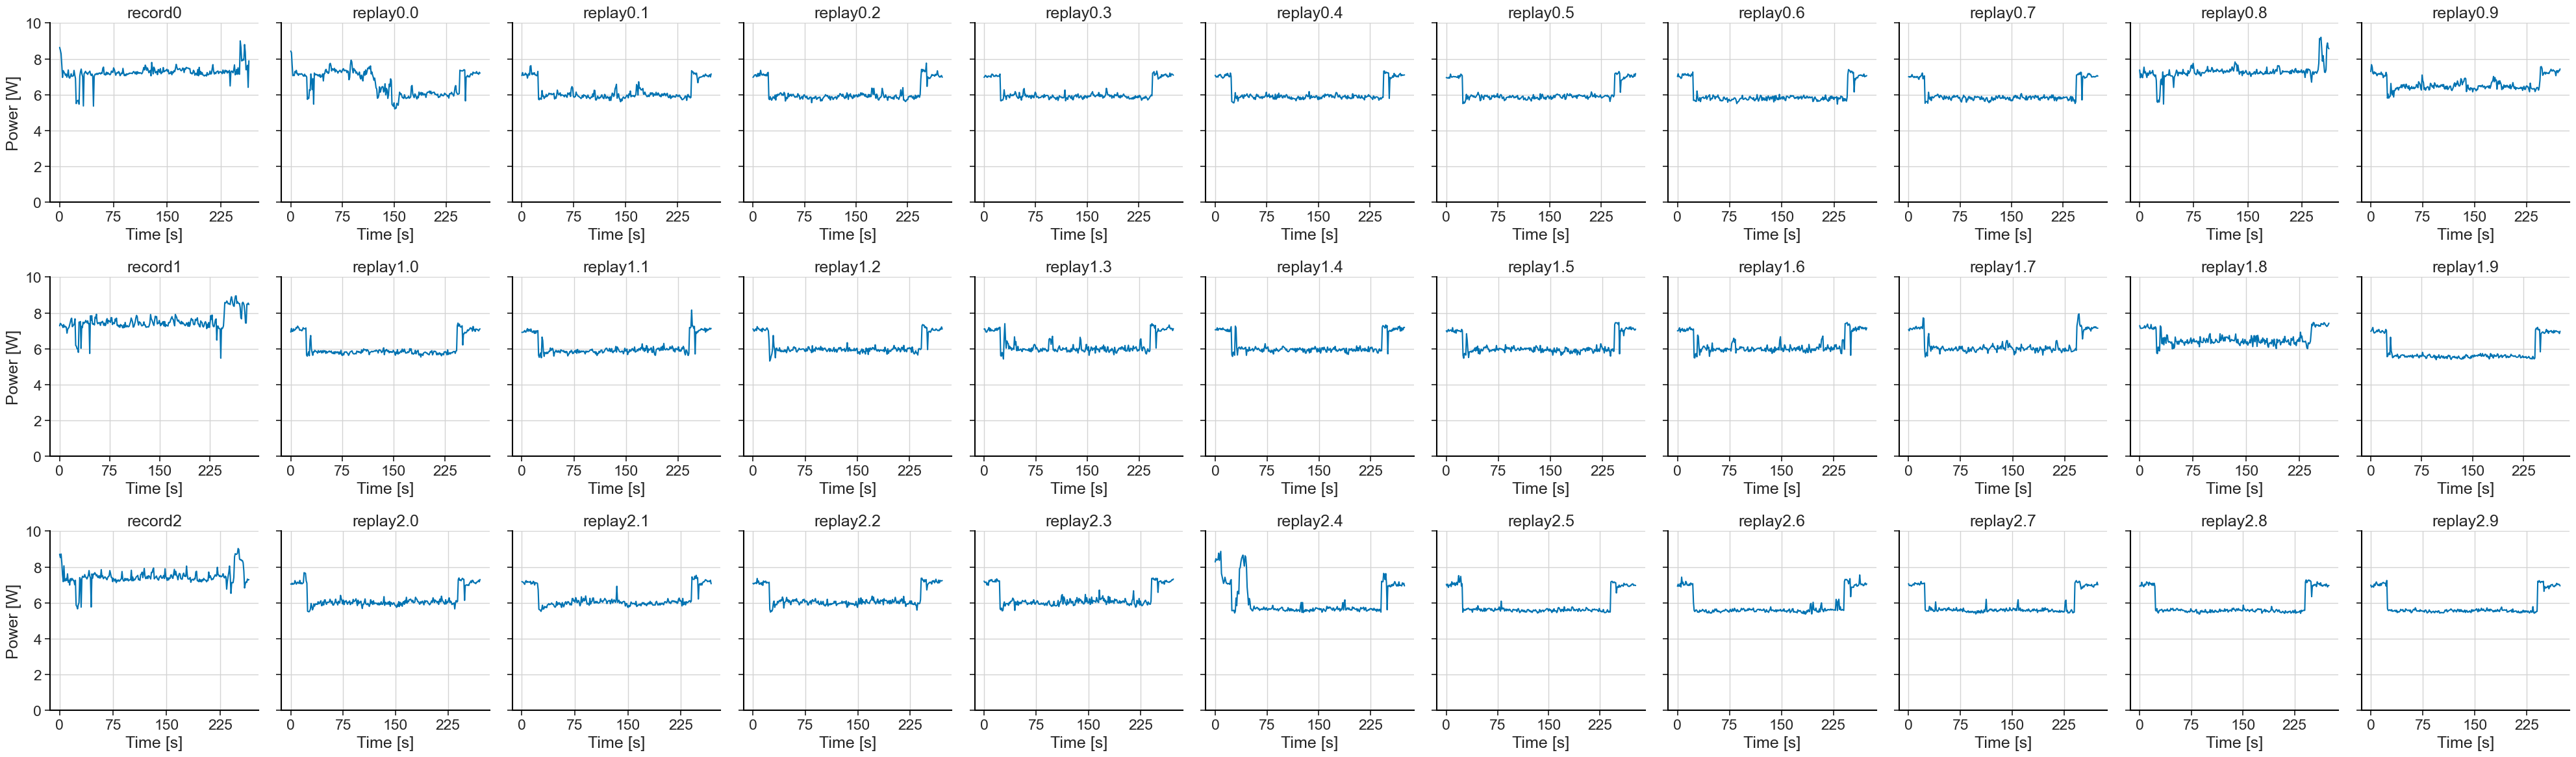

In [17]:
fig, ax = plt.subplots(3, 11, figsize=(40, 12), sharey=True)
for record in range(3):
    df = pd.read_csv(f'{path}record{record}/battery_manager.csv')
    # fig.suptitle('record' + str(record))
    # df = reset_timestamp(df)
    sns.lineplot(data=df, x='Timestamp', y='power', ax=ax[record][0])
    ax[record][0].set_title('record' + str(record))
    ax[record][0].set_xlabel('Time [s]')
    ax[record][0].set_ylabel('Power [W]')
    ax[record][0].set_xticks(np.arange(0, 300, 75))
    ax[record][0].set_ylim(0, 10)
    ax[record][0].set_yticks(np.arange(0, 11, 2))


    for replay in range(10):
        df = pd.read_csv(f'{path}replay{record}.{replay}/battery_manager.csv')
        # df = reset_timestamp(df)
        sns.lineplot(data=df, x='Timestamp', y='power', ax=ax[record][replay + 1])
        ax[record][replay + 1].set_title(f'replay{record}.{replay}')
        ax[record][replay + 1].set_xlabel('Time [s]')
        ax[record][replay + 1].set_xticks(np.arange(0, 300, 75))

plt.tight_layout()
plt.savefig(f'./figures/replay_investigation/power_recordings.pdf', format='pdf')
plt.show()

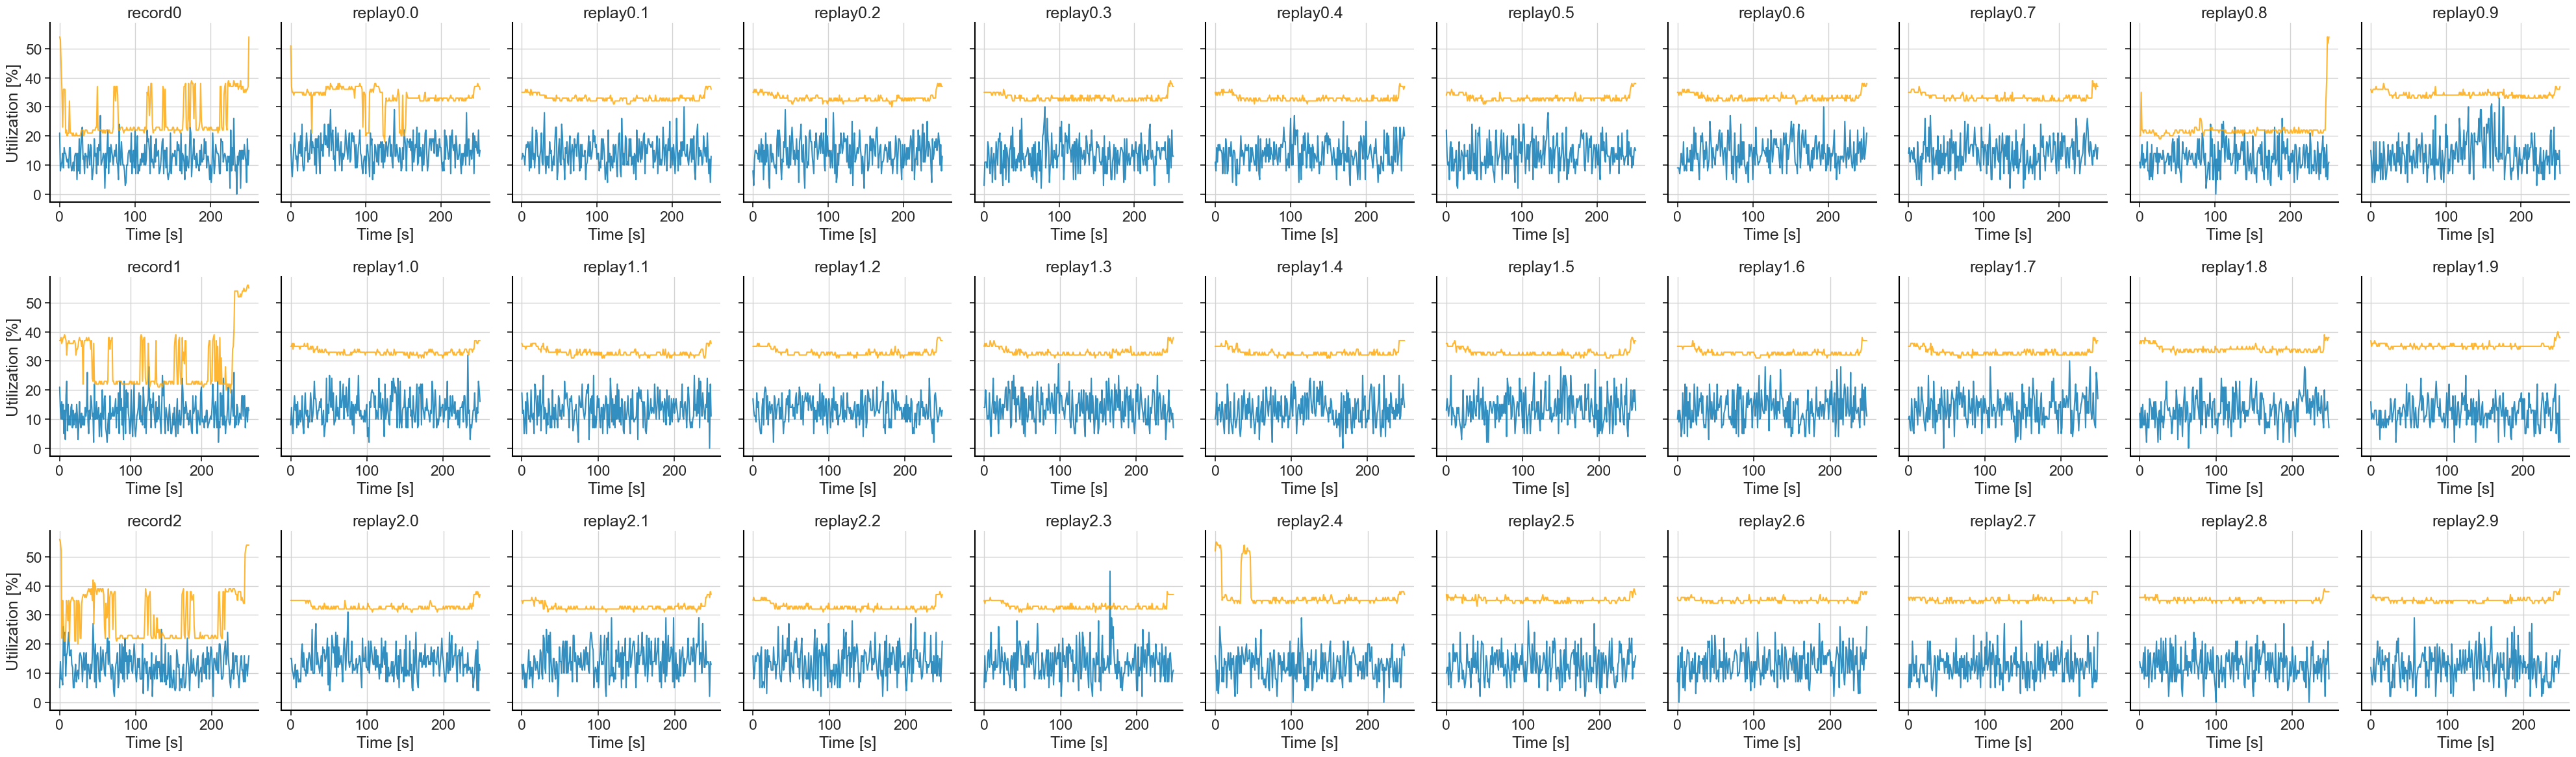

In [18]:
def reset_timestamp(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M:%S.%f")
  df['timestamp'] = df['timestamp'] - df['timestamp'][0]
  # convert to milliseconds
  df['timestamp'] = df['timestamp'].dt.total_seconds()
  return df

fig, ax = plt.subplots(3, 11, figsize=(40, 12), sharey=True)
for record in range(3):
    df = pd.read_csv(f'{path}record{record}/logcat_VrApi.csv')
    df['CPU%'] = df['CPU%'].apply(lambda x: float(x.split('(')[0])*100)
    df['GPU%'] = df['GPU%'].apply(lambda x: float(x)*100)
    # print(df['CPU%'].dtype, df['CPU%'].head(1))
    # reset timestamp to 0
    df = reset_timestamp(df)

    sns.lineplot(data=df, x='timestamp', y='CPU%', label="CPU", ax=ax[record][0], alpha=0.8)
    sns.lineplot(data=df, x='timestamp', y='GPU%', label="GPU", ax=ax[record][0], color="orange", alpha=0.8)
    
    # df['Temp'] = df['Temp'].apply(lambda x: float(x.split('C/')[record][0]))
    # twin = ax[record][0].twinx()
    # sns.lineplot(data=df, x='timestamp', y='Temp', label="Temp", ax=twin, color='r', alpha=0.8)

    ax[record][0].set_yticks(np.arange(0, 101, 10)) 
    ax[record][0].set_ylabel('Utilization [%]')
    ax[record][0].set_xlabel('Time [s]')
    ax[record][0].set_title('record' + str(record))
    ax[record][0].legend().remove()

    for replay in range(10):
        df = pd.read_csv(f'{path}replay{record}.{replay}/logcat_VrApi.csv')
        df['CPU%'] = df['CPU%'].apply(lambda x: float(x.split('(')[0])*100)
        df['GPU%'] = df['GPU%'].apply(lambda x: float(x)*100)
        df = reset_timestamp(df)

        sns.lineplot(data=df, x='timestamp', y='CPU%', label="CPU", ax=ax[record][replay + 1], alpha=0.8)
        sns.lineplot(data=df, x='timestamp', y='GPU%', label="GPU", ax=ax[record][replay + 1], color="orange", alpha=0.8)

        # df['Temp'] = df['Temp'].apply(lambda x: float(x.split('C/')[0]))
        # twin = ax[record][replay + 1].twinx()
        # sns.lineplot(data=df, x='timestamp', y='Temp', label="Temp", ax=twin, color='r', alpha=0.8)

        ax[record][replay + 1].set_title(f'replay{record}.{replay}')
        ax[record][replay + 1].set_xlabel('Time [s]')
        ax[record][replay + 1].legend().remove()

plt.tight_layout()
plt.savefig(f'./figures/replay_investigation/cpu_gpu_recordings.pdf', bbox_inches='tight', format='pdf')
plt.show()